# Métricas de Riesgo de Mercado:
Alumnos:


*   Angeles Castañeda, Harol Emanuel.
*   Ochoa Chamba, Denilson Andre.




In [ ]:
# PARTE 1: Optimización Media-Varianza

#==============================================================================
# 1. Importar Libreria
#==============================================================================
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
#==============================================================================
# 2. Selección de activos
#==============================================================================

# Configuración inicial
initial_investment = 100000
tickers = ["AMZN","GOLD","GOOG","IBM","JPM","META","NVDA","SAN","SMLF","XLV"]
tech_sector = ["NVDA", "GOOG", "AMZN", "META","IBM"]
bank_sector = ["SAN", "JPM"]
other_sector = ["SMLF", "XLV","GOLD"]
start_date = "2021-01-01"
end_date = "2025-01-07"

# Descarga de datos
data = yf.download(tickers, start=start_date, end=end_date)["Close"]
returns = data.pct_change().dropna()


[*********************100%***********************]  10 of 10 completed


In [ ]:
# Resumen Estadistico
summary_stats_data = pd.DataFrame(data.describe().transpose())
summary_stats_data

,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
AMZN,1008.0,150.124184,32.528390,81.820000,125.952124,155.865250,173.699875,232.929993
GOLD,1008.0,17.591040,2.153321,12.442461,15.988167,17.322709,18.910947,23.753792
GOOG,1008.0,131.208545,26.093472,83.191086,110.869133,131.338081,145.078461,198.160004
IBM,1008.0,138.497297,34.565752,94.550941,115.488724,123.721943,157.769154,238.039993
JPM,1008.0,150.655171,34.797483,96.202728,128.138649,140.642838,165.273724,249.003983
META,1008.0,318.163286,134.031075,88.571663,207.250813,309.617294,374.890457,632.170044
NVDA,1008.0,45.935262,39.930509,11.215970,17.675000,26.605623,50.144674,149.429993
SAN,1008.0,3.458858,0.777174,2.078622,2.974054,3.330912,3.915583,5.129508
SMLF,1008.0,53.891029,6.243269,42.772297,49.800235,51.998213,57.114760,73.819855


<ipython-input-3-54fb52f6fb35>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_stocks)


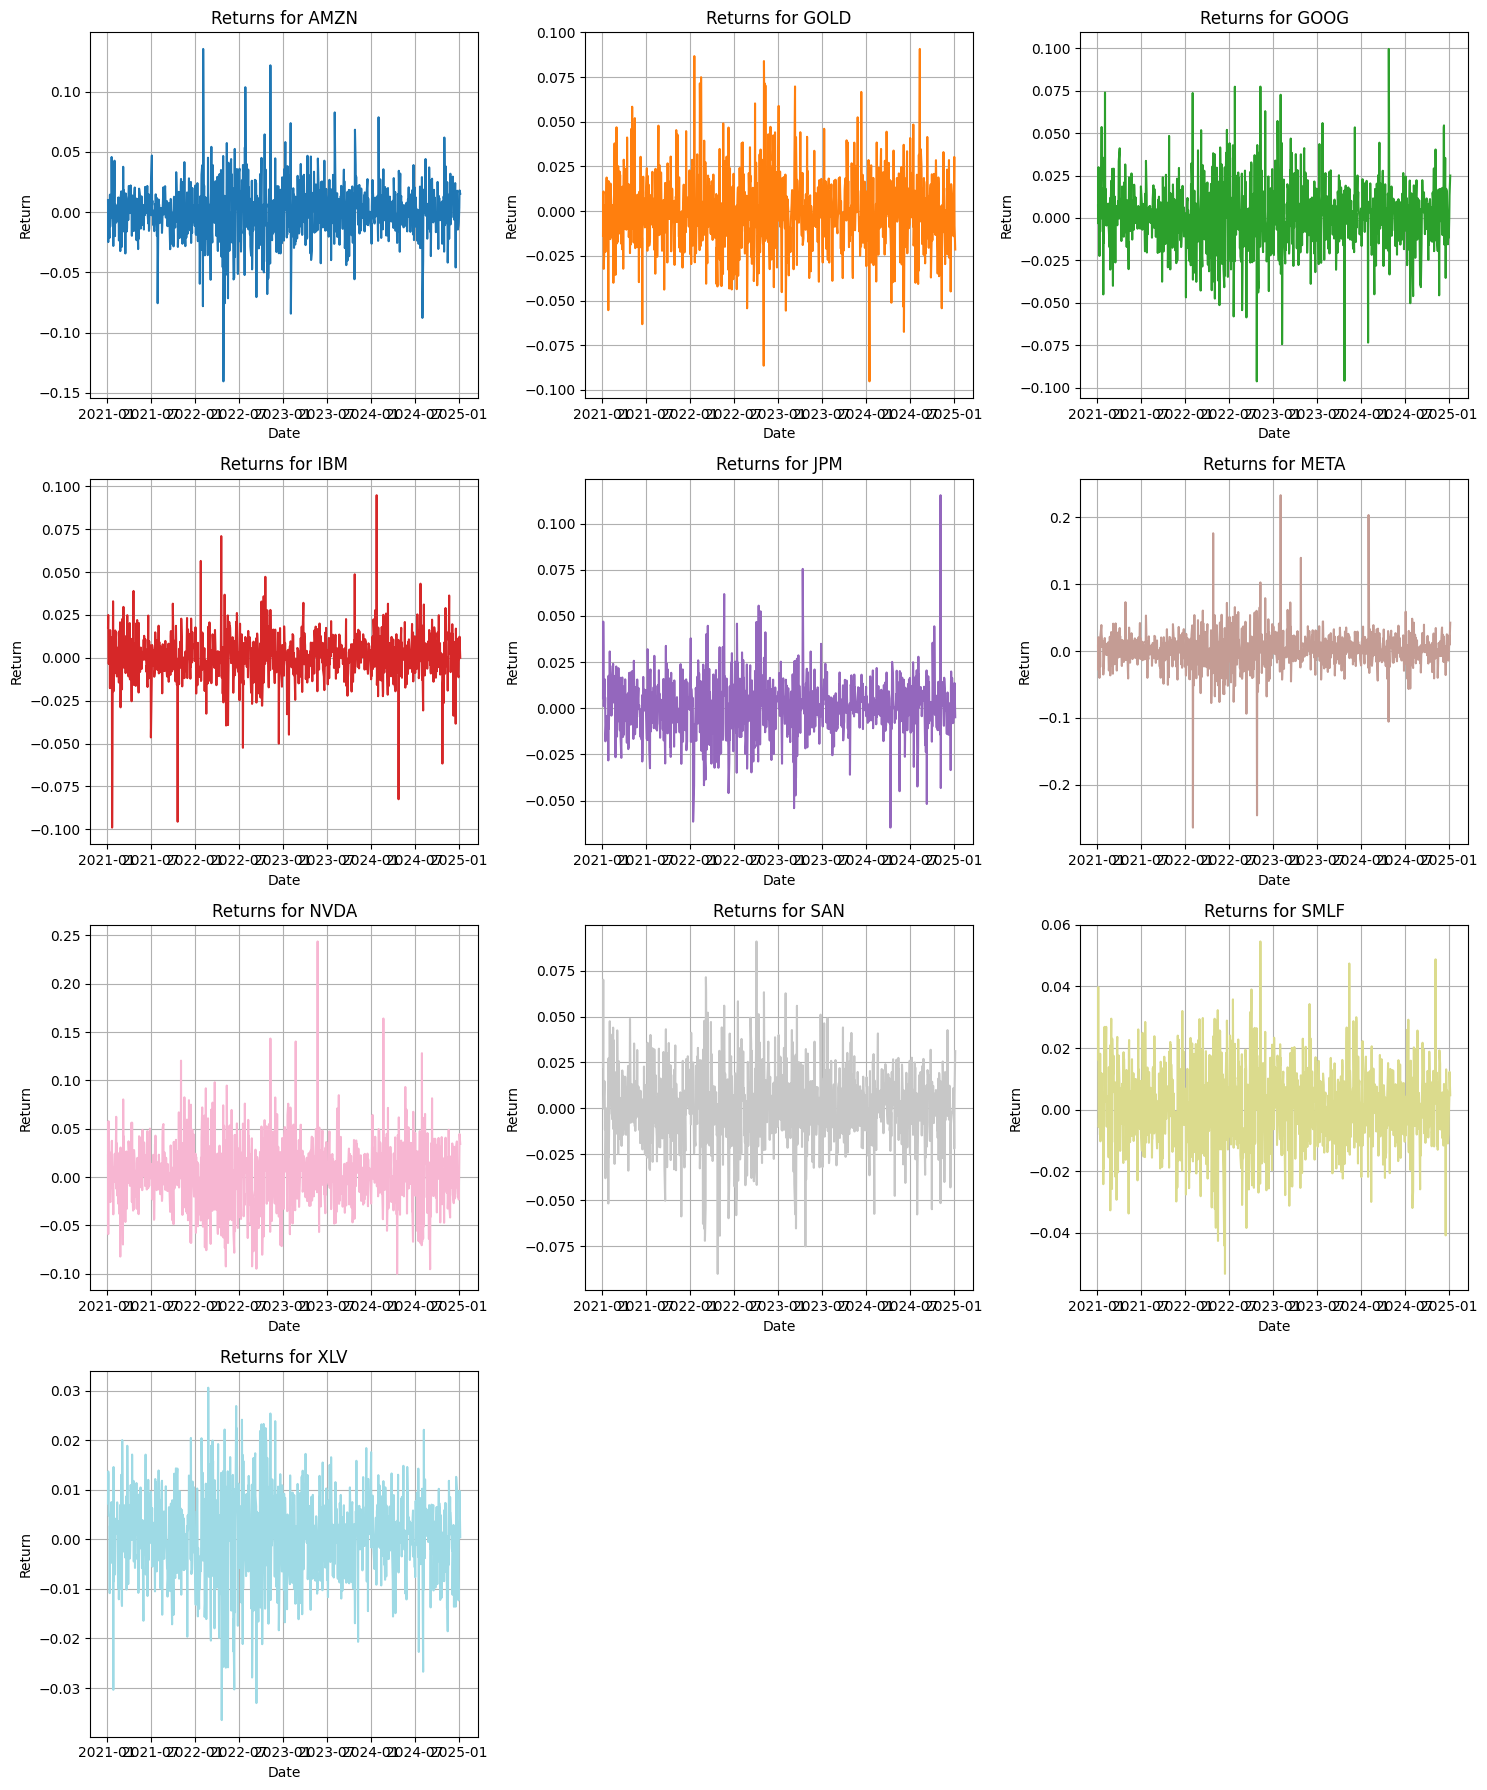

In [ ]:
num_stocks = len(tickers)
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 18))

colors = plt.cm.get_cmap('tab20', num_stocks)

for i, ticker in enumerate(tickers):
    row = i // 3
    col = i % 3
    axes[row, col].plot(returns[ticker], color=colors(i))
    axes[row, col].set_title(f'Returns for {ticker}')
    axes[row, col].set_xlabel('Date')
    axes[row, col].set_ylabel('Return')
    axes[row, col].grid(True)

# Hide any unused subplots
for i in range(num_stocks, 12):
    row = i // 3
    col = i % 3
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#==============================================================================
# 3. Restricciones del Portafolio
#==============================================================================
# Restricciones de optimización
sector_limits = {
    "tech": 0.5,
    "bank": 0.25,
    "other": 0.25
}
asset_limit = 0.20

# Función para calcular retorno esperado y matriz de covarianza
expected_returns = returns.mean() * 252 #anual
expected_returns_1d = returns.mean()
expected_std = returns.std() * np.sqrt(252) #anual
expected_std_1d = returns.std()
cov_matrix = returns.cov() * 252

# Función objetivo para minimizar riesgo (varianza)
def portfolio_variance(weights):
    return weights.T @ cov_matrix @ weights

# Restricciones de optimización
def sector_constraint(weights):
    tech_weight = sum(weights[tickers.index(t)] for t in tech_sector)
    bank_weight = sum(weights[tickers.index(t)] for t in bank_sector)
    other_weight = sum(weights[tickers.index(t)] for t in other_sector)
    return [
        tech_weight - sector_limits["tech"],
        bank_weight - sector_limits["bank"],
        other_weight - sector_limits["other"],
    ]

def weight_constraints(weights):
    return [1 - sum(weights)] + [w - asset_limit for w in weights]

# Configuración de restricciones y límites
constraints = (
    {"type": "eq", "fun": lambda w: sum(w) - 1},  # Suma de pesos igual a 1
    {"type": "ineq", "fun": lambda w: -np.array(sector_constraint(w))},
    {"type": "ineq", "fun": lambda w: -np.array(weight_constraints(w))},
)
bounds = [(0, asset_limit) for _ in tickers]


In [ ]:
#==============================================================================
# 4. Optimización del Portafolio
#==============================================================================

# Definimos los pesos iniciales iguales para cada activo
initial_weights = np.array([1/len(tickers)] * len(tickers))

# Optimizamos el portafolio
result = minimize(portfolio_variance, initial_weights, bounds=bounds, constraints=constraints)
optimal_weights = result.x

In [ ]:
#==============================================================================
# 5. Presentación de Resultados
#==============================================================================

# Agregamos resultados de los pesos optimo a la tabla resumen
summary_stats_data['PesosOptimos'] = optimal_weights

# Resultados
portfolio_return = sum(optimal_weights * expected_returns)
portfolio_volatility = np.sqrt(portfolio_variance(optimal_weights))
optimal_weights_dict = dict(zip(tickers, optimal_weights))

# Cálculo del Market Value de cada activo
market_values = initial_investment * optimal_weights

# Crear un diccionario con los valores de mercado por activo
market_value_dict = dict(zip(tickers, market_values))

# Mostrar resultado
print("Pesos Óptimos del Portafolio:", optimal_weights_dict)
print("Retorno Esperado del Portafolio:", portfolio_return)
print("Volatilidad del Portafolio:", portfolio_volatility)
print("Market Value por activo:", market_value_dict)
print("Market Value total del portafolio:", sum(market_values))

Pesos Óptimos del Portafolio: {'AMZN': 0.09726112205535173, 'GOLD': 0.08425886301641693, 'GOOG': 0.1388412333454117, 'IBM': 0.19999999999999998, 'JPM': 0.14990458109343124, 'META': 0.056771258591624685, 'NVDA': 0.00712638600761175, 'SAN': 0.10009541890656871, 'SMLF': 0.042723629658066004, 'XLV': 0.1230175073255172}
Retorno Esperado del Portafolio: 0.18367468914864585
Volatilidad del Portafolio: 0.17287794717052585
Market Value por activo: {'AMZN': 9726.112205535173, 'GOLD': 8425.886301641693, 'GOOG': 13884.123334541171, 'IBM': 20000.0, 'JPM': 14990.458109343124, 'META': 5677.125859162468, 'NVDA': 712.638600761175, 'SAN': 10009.541890656872, 'SMLF': 4272.3629658066, 'XLV': 12301.75073255172}
Market Value total del portafolio: 99999.99999999999


In [ ]:
summary_stats_data['PesosOptimos']

,PesosOptimos
Ticker,
AMZN,0.097261
GOLD,0.084259
GOOG,0.138841
IBM,0.200000
JPM,0.149905
META,0.056771
NVDA,0.007126
SAN,0.100095
SMLF,0.042724


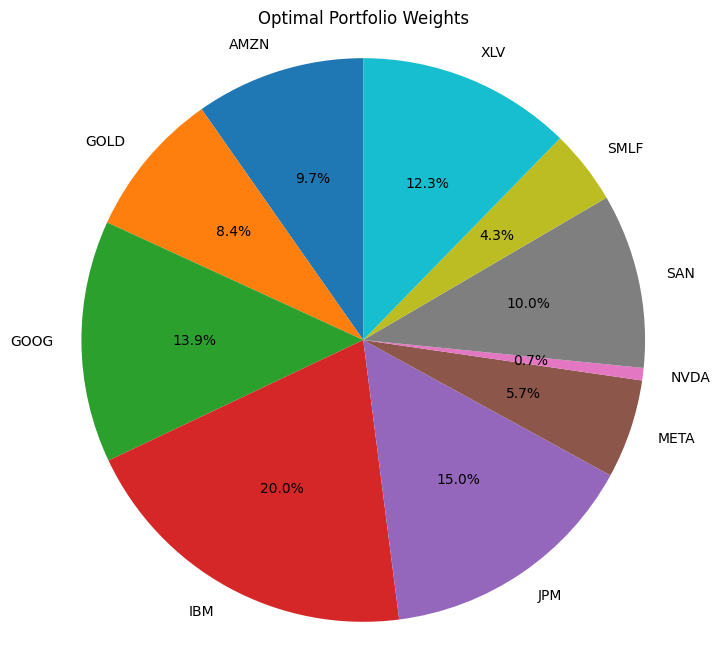

In [ ]:
labels = optimal_weights_dict.keys()
sizes = optimal_weights_dict.values()

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Optimal Portfolio Weights')
plt.axis('equal')
plt.show()



In [ ]:
summary_stats_data

,count,mean,std,min,25%,50%,75%,max,PesosOptimos
Ticker,,,,,,,,,
AMZN,1008.0,150.124184,32.528390,81.820000,125.952124,155.865250,173.699875,232.929993,0.097261
GOLD,1008.0,17.591040,2.153321,12.442461,15.988167,17.322709,18.910947,23.753792,0.084259
GOOG,1008.0,131.208545,26.093472,83.191086,110.869133,131.338081,145.078461,198.160004,0.138841
IBM,1008.0,138.497297,34.565752,94.550941,115.488724,123.721943,157.769154,238.039993,0.200000
JPM,1008.0,150.655171,34.797483,96.202728,128.138649,140.642838,165.273724,249.003983,0.149905
META,1008.0,318.163286,134.031075,88.571663,207.250813,309.617294,374.890457,632.170044,0.056771
NVDA,1008.0,45.935262,39.930509,11.215970,17.675000,26.605623,50.144674,149.429993,0.007126
SAN,1008.0,3.458858,0.777174,2.078622,2.974054,3.330912,3.915583,5.129508,0.100095
SMLF,1008.0,53.891029,6.243269,42.772297,49.800235,51.998213,57.114760,73.819855,0.042724


In [ ]:
# Configuración para VaR
start_var_date = "2024-01-01"
end_var_date = "2025-01-07"
data_var = yf.download(tickers, start=start_var_date, end=end_var_date)["Close"]
returns_var = data_var.pct_change().dropna()


asset_investment = initial_investment*optimal_weights #Inversion USD
summary_stats_data['Asset_Inv'] = asset_investment

num_stock = asset_investment/ data_var.iloc[0]
summary_stats_data['num_stock'] = num_stock

# VaR Parametrico
#------------------------------------
position_value = asset_investment #Inversion USD
returns_std = expected_std_1d
nivel_confianza = 0.99
z_score = norm.ppf(1-nivel_confianza)

var_parametric_1d = position_value*returns_std*z_score
summary_stats_data['var_par_1d'] = var_parametric_1d
#summary_stats_data['var_par_1a'] = var_parametric_1d*np.sqrt(252)

[*********************100%***********************]  10 of 10 completed


In [ ]:
var_parametric_1d #EN USD

,0
Ticker,
AMZN,-502.531493
GOLD,-404.845123
GOOG,-625.126270
IBM,-635.512473
JPM,-529.717041
META,-371.621993
NVDA,-55.219799
SAN,-483.078008
SMLF,-131.460097


In [ ]:
# VaR en USD
var_portfolio_usd = initial_investment * portfolio_volatility * z_score

# VaR en porcentaje
var_portfolio_pct = portfolio_volatility * z_score

print("El VaR del portafolio es {:.2f}%, lo que representa una pérdida de {:.2f} USD".format(var_portfolio_pct*100,var_portfolio_usd))

El VaR del portafolio es -40.22%, lo que representa una pérdida de -40217.42 USD


In [ ]:
summary_stats_data.index

Index(['AMZN', 'GOLD', 'GOOG', 'IBM', 'JPM', 'META', 'NVDA', 'SAN', 'SMLF',
       'XLV'],
      dtype='object', name='Ticker')

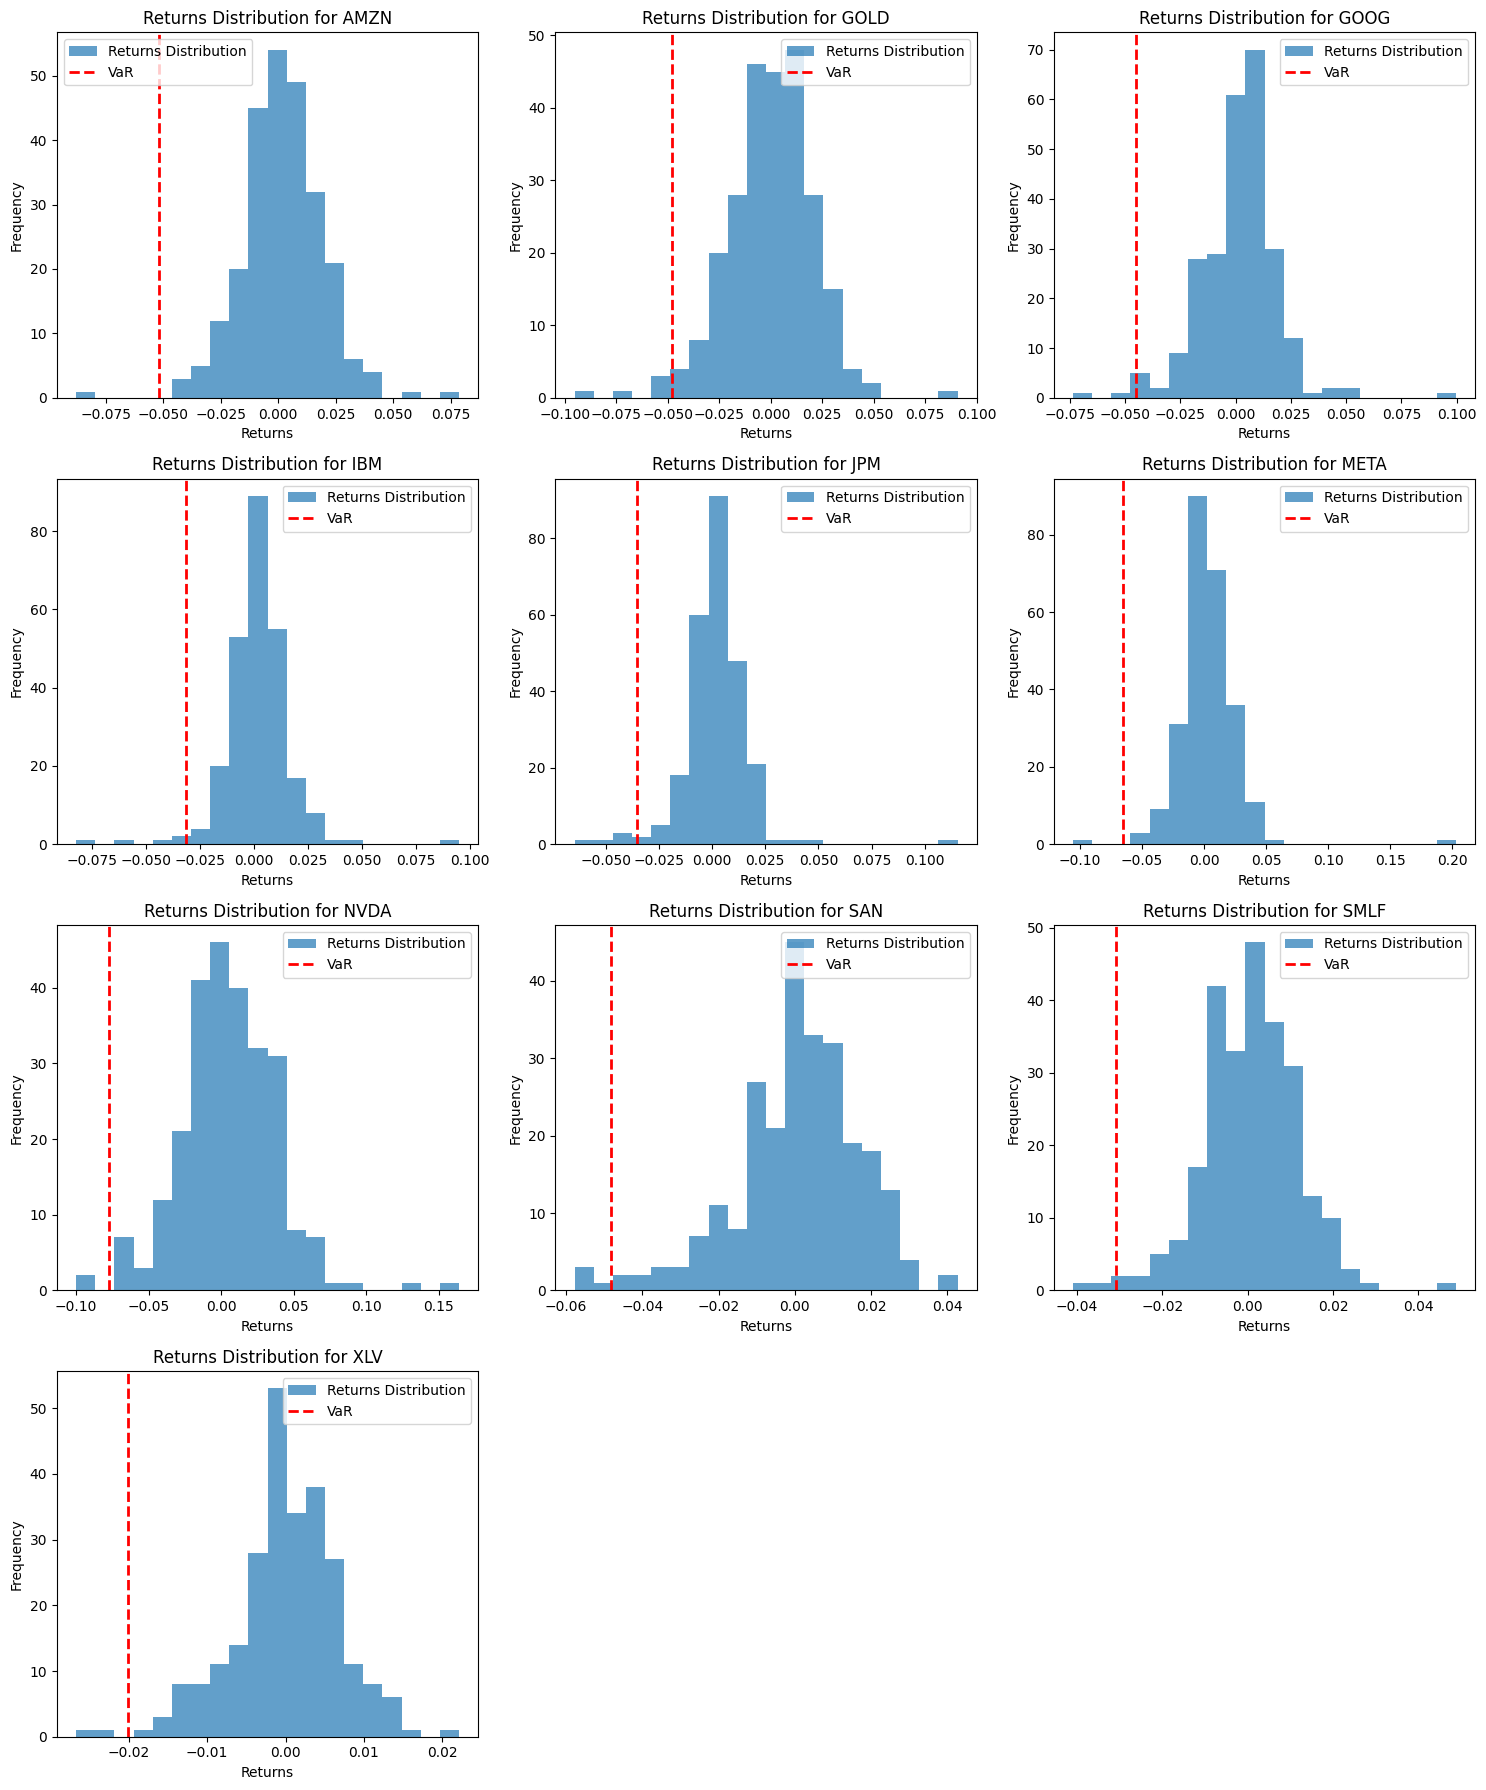

In [ ]:
# Determina el número de filas y columnas necesarias
ncols = 3
nrows = (len(summary_stats_data.index) + ncols - 1) // ncols  # Calcula el número de filas necesarias

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 18))

for i, ticker in enumerate(summary_stats_data.index):
    row = i // ncols
    col = i % ncols

    axes[row, col].hist(returns_var[ticker], bins=20, alpha=0.7, label='Returns Distribution')

    var_value = summary_stats_data.loc[ticker, 'var_par_1d']

    axes[row, col].axvline(x=var_value / asset_investment[i], color='red', linestyle='dashed', linewidth=2, label='VaR')
    axes[row, col].set_title(f'Returns Distribution for {ticker}')
    axes[row, col].set_xlabel('Returns')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend()

# Ocultar subplots no utilizados
for i in range(len(summary_stats_data.index), nrows * ncols):
    row = i // ncols
    col = i % ncols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# VaR Simulación Historica
#------------------------------------
var_historical_1d = returns.quantile(1-nivel_confianza) * position_value #VaR en USD
summary_stats_data['var_hist_1d'] = var_historical_1d

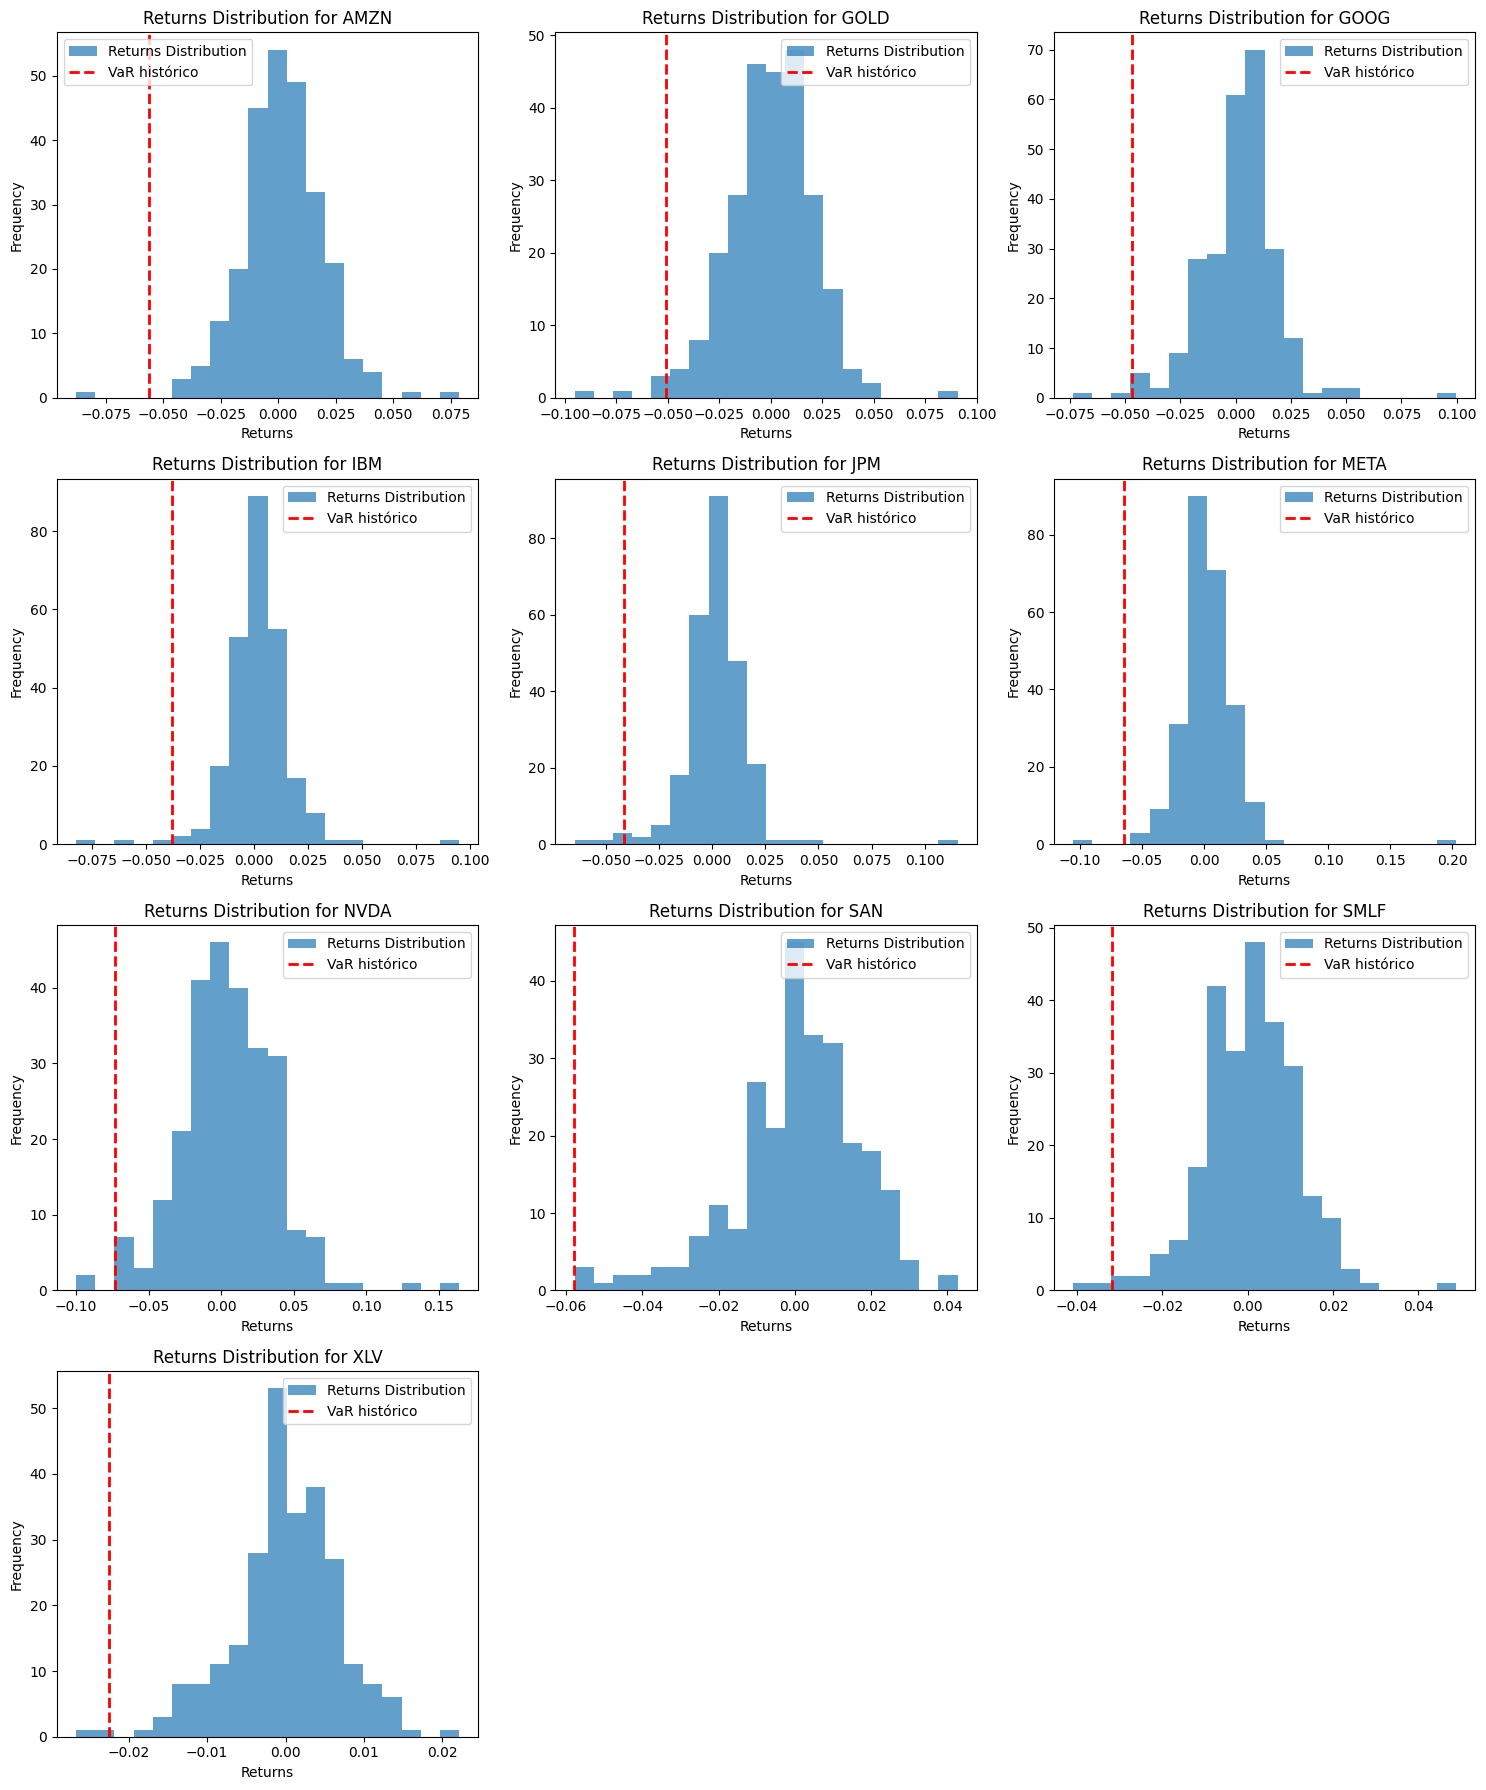

In [ ]:
# Determina el número de filas y columnas necesarias
ncols = 3
nrows = (len(summary_stats_data.index) + ncols - 1) // ncols  # Calcula el número de filas necesarias

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 18))

for i, ticker in enumerate(summary_stats_data.index):
    row = i // ncols
    col = i % ncols

    axes[row, col].hist(returns_var[ticker], bins=20, alpha=0.7, label='Returns Distribution')

    var_value = summary_stats_data.loc[ticker, 'var_hist_1d']

    axes[row, col].axvline(x=var_value / asset_investment[i], color='red', linestyle='dashed', linewidth=2, label='VaR histórico')
    axes[row, col].set_title(f'Returns Distribution for {ticker}')
    axes[row, col].set_xlabel('Returns')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend()

# Ocultar subplots no utilizados
for i in range(len(summary_stats_data.index), nrows * ncols):
    row = i // ncols
    col = i % ncols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
summary_stats_data['var_hist_1d']

,var_hist_1d
Ticker,
AMZN,-546.655689
GOLD,-428.730267
GOOG,-649.566811
IBM,-763.071288
JPM,-622.293467
META,-364.466121
NVDA,-52.190953
SAN,-578.992607
SMLF,-135.707654


In [ ]:
summary_stats_data

,count,mean,std,min,25%,50%,75%,max,PesosOptimos,Asset_Inv,num_stock,var_par_1d,var_hist_1d
Ticker,,,,,,,,,,,,,
AMZN,1008.0,150.124184,32.528390,81.820000,125.952124,155.865250,173.699875,232.929993,0.097261,9726.112206,64.871024,-502.531493,-546.655689
GOLD,1008.0,17.591040,2.153321,12.442461,15.988167,17.322709,18.910947,23.753792,0.084259,8425.886302,479.666895,-404.845123,-428.730267
GOOG,1008.0,131.208545,26.093472,83.191086,110.869133,131.338081,145.078461,198.160004,0.138841,13884.123335,99.842443,-625.126270,-649.566811
IBM,1008.0,138.497297,34.565752,94.550941,115.488724,123.721943,157.769154,238.039993,0.200000,20000.000000,128.315790,-635.512473,-763.071288
JPM,1008.0,150.655171,34.797483,96.202728,128.138649,140.642838,165.273724,249.003983,0.149905,14990.458109,89.654166,-529.717041,-622.293467
META,1008.0,318.163286,134.031075,88.571663,207.250813,309.617294,374.890457,632.170044,0.056771,5677.125859,16.456762,-371.621993,-364.466121
NVDA,1008.0,45.935262,39.930509,11.215970,17.675000,26.605623,50.144674,149.429993,0.007126,712.638601,14.799050,-55.219799,-52.190953
SAN,1008.0,3.458858,0.777174,2.078622,2.974054,3.330912,3.915583,5.129508,0.100095,10009.541891,2507.292691,-483.078008,-578.992607
SMLF,1008.0,53.891029,6.243269,42.772297,49.800235,51.998213,57.114760,73.819855,0.042724,4272.362966,74.183636,-131.460097,-135.707654


In [ ]:
# VaR Simulación Montecarlo
#------------------------------------

# Iniciamos la simulacion de montecarlo
var_montecarlo_1d = np.zeros(len(summary_stats_data.index))
T = 1  # Tiempo hasta el vencimiento
N = 100  # Número de pasos en la simulación de Monte Carlo
M = 1000  # Número de trayectorias de Monte Carlo
dt = T / N


for i in range(len(summary_stats_data.index)):
    # Definir los parámetros de los activos
    S0 = data_var.iloc[i]  # Precio inicial del activo subyacente
    r = expected_returns.iloc[i]  # Tasa libre de riesgo anual
    sigma = expected_std.iloc[i]  # Volatilidad anual

    # Simulación de Monte Carlo
    S_t = np.zeros((M, N + 1))
    S_t[:, 0] = S0.iloc[i]
    for j in range(1, N + 1):
        S_t[:, j] = S_t[:, j - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * np.random.normal(size=M))

    returns_MC = np.diff(S_t, axis=1) / S_t[:, :-1]
    returns_SMC = returns_MC[:, -1]

    # Cálculo del VaR SMC al 95%
    var_montecarlo_1d[i] = np.percentile(returns_SMC, 5) * position_value[i]
# Incluir el el reporte los resultados del VaR SM
summary_stats_data['var_SM_1d'] = var_montecarlo_1d

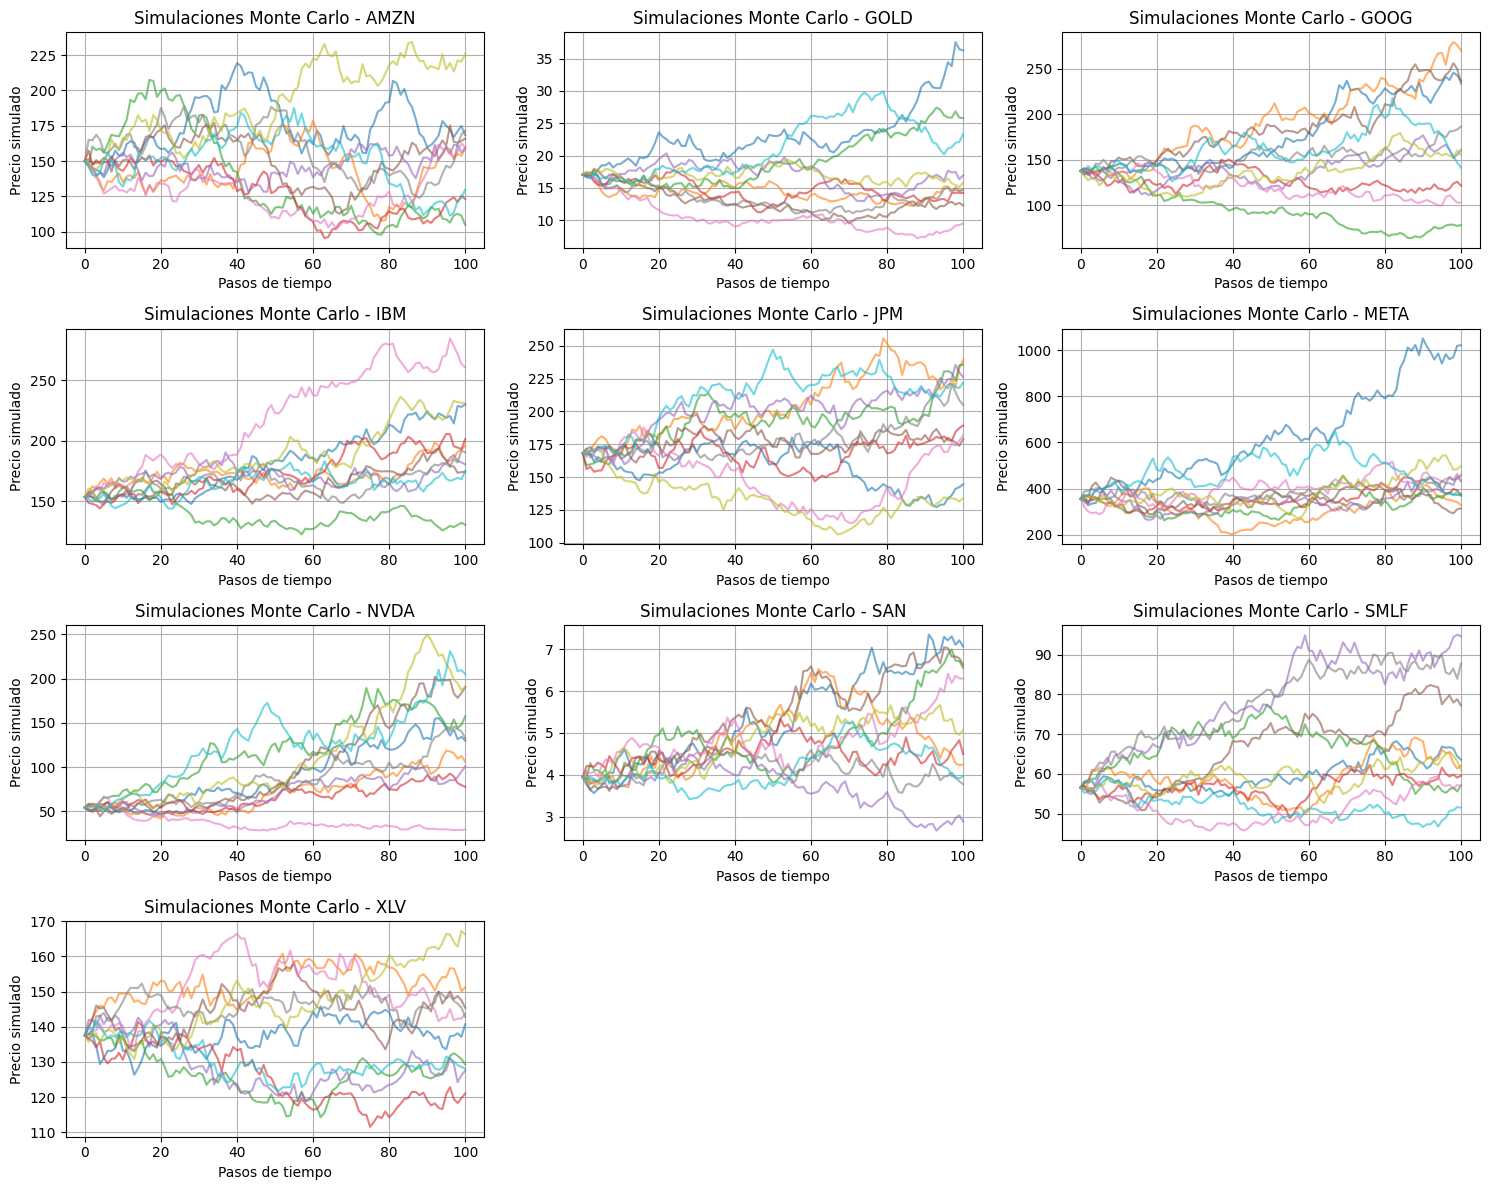

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Configuración del panel 3x3
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()  # Convertimos en una lista para iterar fácilmente

for i, ticker in enumerate(tickers):
    # Parámetros del activo
    S0 = data_var.iloc[i]  # Precio inicial
    r = expected_returns.iloc[i]  # Tasa libre de riesgo
    sigma = expected_std.iloc[i]  # Volatilidad anual

    # Simulación de Monte Carlo
    S_t = np.zeros((M, N + 1))
    S_t[:, 0] = S0.iloc[i]

    for j in range(1, N + 1):
        S_t[:, j] = S_t[:, j - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * np.random.normal(size=M))

    # Graficamos 10 trayectorias simuladas
    for k in range(10):
        axes[i].plot(S_t[k], alpha=0.6)

    # Configuración del subplot
    axes[i].set_title(f'Simulaciones Monte Carlo - {ticker}')
    axes[i].set_xlabel('Pasos de tiempo')
    axes[i].set_ylabel('Precio simulado')
    axes[i].grid(True)

    # Ocultar subplots no utilizados
    for i in range(len(tickers), nrows * ncols):
      axes[i].axis('off')

# Ajustar el layout
plt.tight_layout()
plt.show()

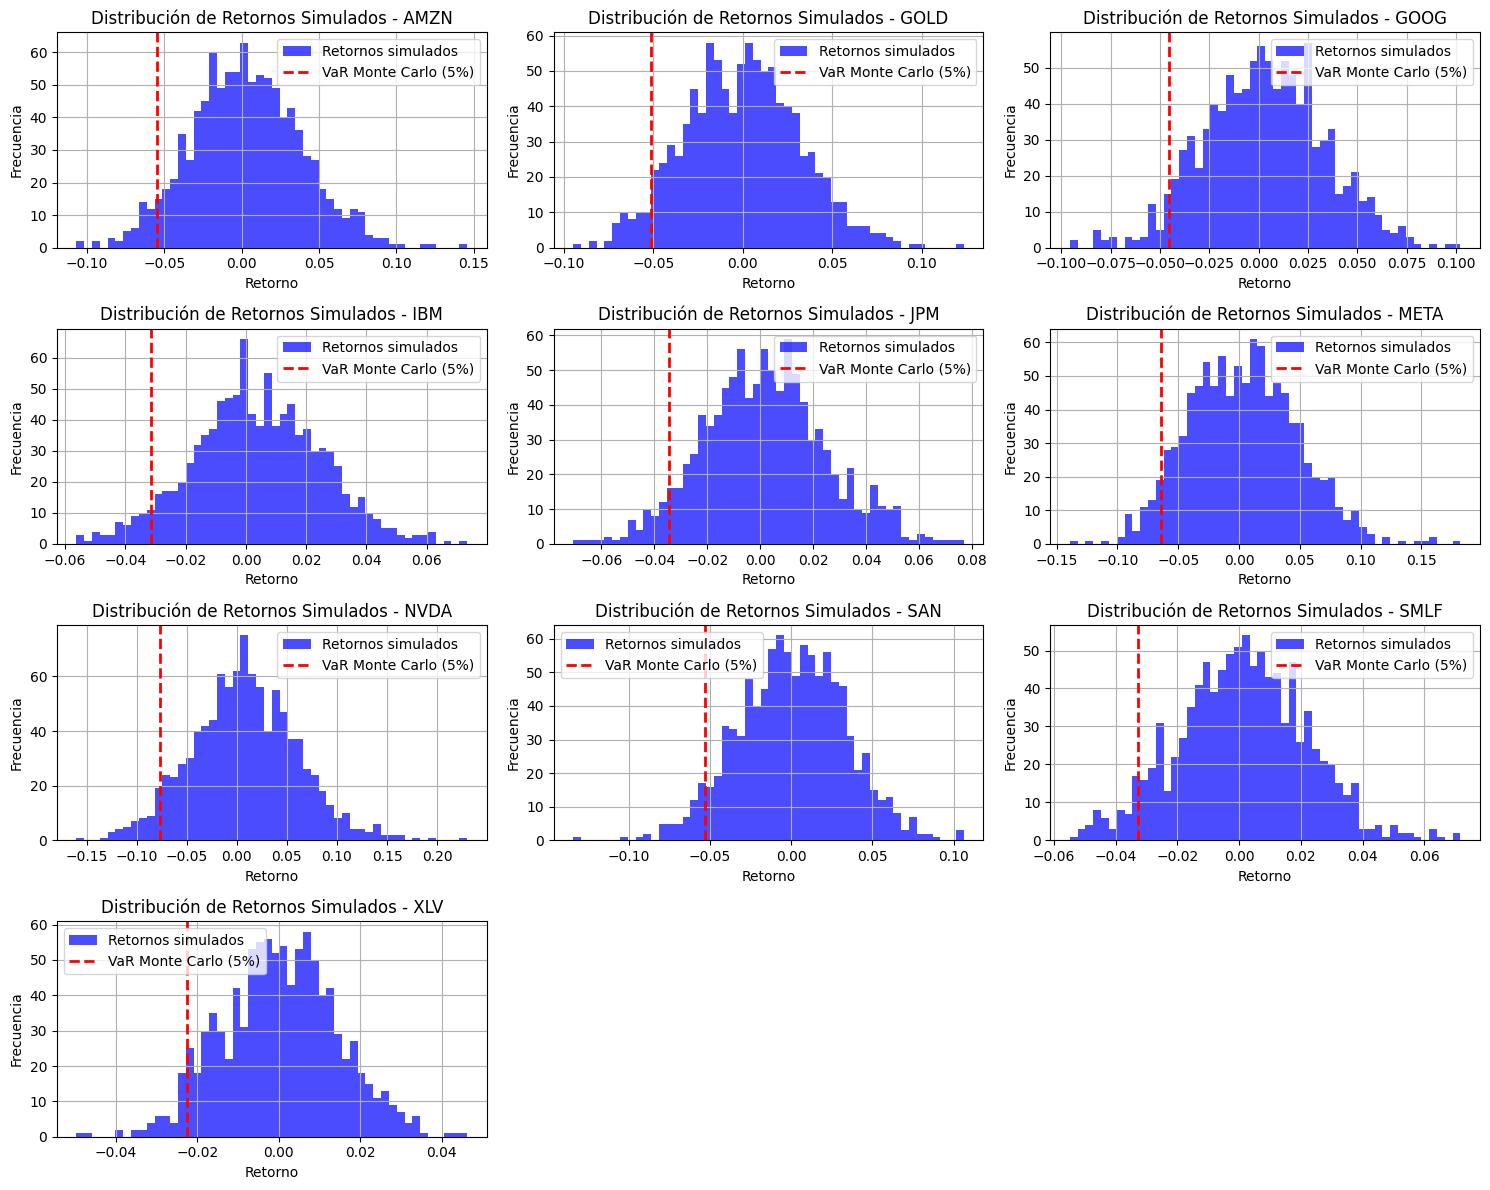

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()  # Convertimos en lista para iterar

for i, ticker in enumerate(tickers):
    # Parámetros del activo
    S0 = data_var.iloc[i]  # Precio inicial
    r = expected_returns.iloc[i]  # Tasa libre de riesgo
    sigma = expected_std.iloc[i]  # Volatilidad anual

    # Simulación de Monte Carlo
    S_t = np.zeros((M, N + 1))
    S_t[:, 0] = S0.iloc[i]

    for j in range(1, N + 1):
        S_t[:, j] = S_t[:, j - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * np.random.normal(size=M))

    returns_MC = np.diff(S_t, axis=1) / S_t[:, :-1]
    returns_SMC = returns_MC[:, -1]

    # Cálculo del VaR Monte Carlo al 95%
    var_montecarlo_1d[i] = np.percentile(returns_SMC, 5) * position_value[i]

    # Graficamos el histograma de los retornos simulados
    axes[i].hist(returns_SMC, bins=50, alpha=0.7, color='b', label='Retornos simulados')

    # Línea del VaR Monte Carlo
    axes[i].axvline(x=np.percentile(returns_SMC, 5), color='r', linestyle='dashed', linewidth=2, label='VaR Monte Carlo (5%)') #VaR en %

    # Configuración del subplot
    axes[i].set_title(f'Distribución de Retornos Simulados - {ticker}')
    axes[i].set_xlabel('Retorno')
    axes[i].set_ylabel('Frecuencia')
    axes[i].legend()
    axes[i].grid(True)

    # Ocultar subplots no utilizados
    for i in range(len(tickers), nrows * ncols):
      axes[i].axis('off')

# Ajustar el layout
plt.tight_layout()
plt.show()

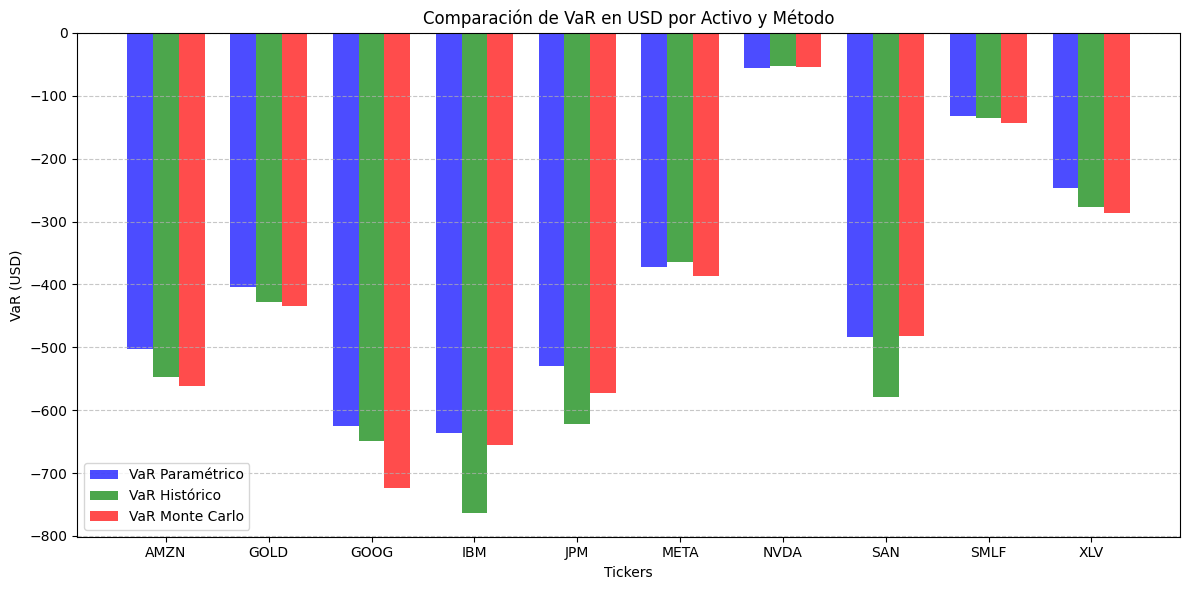

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer datos de VaR
tickers = summary_stats_data.index
var_par = summary_stats_data['var_par_1d']
var_hist = summary_stats_data['var_hist_1d']
var_mc = summary_stats_data['var_SM_1d']

# Configuración del gráfico
x = np.arange(len(tickers))  # Posiciones en el eje x
width = 0.25  # Ancho de las barras

fig, ax = plt.subplots(figsize=(12, 6))

# Graficar las barras para cada método
ax.bar(x - width, var_par, width, label='VaR Paramétrico', color='b', alpha=0.7)
ax.bar(x, var_hist, width, label='VaR Histórico', color='g', alpha=0.7)
ax.bar(x + width, var_mc, width, label='VaR Monte Carlo', color='r', alpha=0.7)

# Etiquetas y título

# Etiquetas y formato
ax.set_xlabel("Tickers")
ax.set_ylabel("VaR (USD)")
ax.set_title("Comparación de VaR en USD por Activo y Método")
ax.set_xticks(x)
ax.set_xticklabels(tickers, rotation=0)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
summary_stats_data.to_excel('data_pefa.xlsx', index=True)

In [ ]:
from google.colab import files

# Descargamos el archivo
files.download('data_pefa.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>